In [1]:
from tensorflow.keras.datasets import cifar10
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.applications.vgg19 import VGG19, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import cv2
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as BE
from tensorflow.keras.losses import categorical_crossentropy
from progressbar import ProgressBar
import os
import scipy.io
import tensorflow as tf
import json
import sys
sys.path.append('..')  
from GradPri_utils.utils import *

# from tensorflow.keras import backend as BE
# from Integrated_Gradients_algorithm import *
# from GradVisualizer import *

os.environ["CUDA_VISIBLE_DEVICES"] = "4"
config=tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.compat.v1.Session(config=config) 

# tf.compat.v1.disable_eager_execution()
# tf.compat.v1.enable_eager_execution()

In [2]:
DATA_PATH = '../datasets/ImageNetVal/'
file_name = getfile_name(DATA_PATH)
file_name = np.sort(file_name)

f = open("../datasets/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt",encoding = "utf-8")
val_ground_truth = f.read()
val_ground_truth = val_ground_truth.split('\n')
for i in range(len(val_ground_truth)-1):
    val_ground_truth[i] = int(val_ground_truth[i])

    
vgg19_json = json.load(open('/public/liujiawei/.keras/models/imagenet_class_index.json','r',encoding="utf-8"))

In [3]:
base_model = VGG19(weights='imagenet')

In [4]:
synsets = scipy.io.loadmat(os.path.join('/public/liujiawei/huawei/ZHB/ADF-master/datasets', 'ILSVRC2012_devkit_t12', 'data', 'meta.mat'))['synsets']

ILSVRC2012_ID = [s[0][0][0][0] for s in synsets]

index1 = 821
WNID = [s[0][1][0] for s in synsets]
print(WNID[index1])

words = [s[0][2][0] for s in synsets]
print(words[index1])

num_train_images = [s[0][7][0][0] for s in synsets]
print(num_train_images[0])

n04263257
soup bowl
1300


In [5]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
Gini = []
top_set = 1 # 预测的前n个类中包含真实标签则表示预测正确
total_sample_num = 100
img_num = range(0, total_sample_num)
ground_truth_label = []  # 记录样本的真实标签
predicted_confidence = []  # 记录样本的置信度信息
Gini = []

pbar = ProgressBar()
for i in pbar(img_num):
    img_path = DATA_PATH + file_name[i]
    img = image.load_img(img_path, target_size=(224, 224))
    x_tmp = image.img_to_array(img)
    x_tmp = np.expand_dims(x_tmp, axis=0)
    x_tmp = preprocess_input(x_tmp)
    pre_tmp = base_model.predict(np.reshape(x_tmp, [-1,224,224,3]))
    
    Gini.append(1-np.sum(pre_tmp*pre_tmp))
    predicted_confidence.append(pre_tmp)
    ground_truth_label.append(WNID[val_ground_truth[i]-1])

100% |########################################################################|


In [7]:
indexs = np.argsort(Gini)
indexs = indexs[::-1]
top_set=1
# 计算APFD指标
APFD,_,_ = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                    predicted_confidence=np.array(predicted_confidence), top_set=top_set,
                    decode_predictions=decode_predictions)
print("APFD: ", APFD)

# 计算RAUC指标
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                    predicted_confidence=np.array(predicted_confidence), top_set=top_set,
                    decode_predictions=decode_predictions)
print("RAUC: ", RAUC)

100% |########################################################################|


APFD:  0.777
RAUC:  0.9301204819277108


In [98]:
from functools import reduce
from art.utils import random_sphere
from art.config import ART_NUMPY_DTYPE
import sys
sys.path.append('..')  
from GradPri_utils.utils import *
from scipy.stats import weibull_min
from scipy.optimize import fmin as scipy_optimizer

def inverper_c(classifier, x, nb_batches, batch_size, radius, norm, c_init=1.0, pool_factor=5, prob_constant=0.05):
    """"

    x: np.ndarray,
    nb_batches: int,
    batch_size: int,
    radius: float,
    norm: float,
    c_init: float = 1.0,
    pool_factor: int = 10,
    prob_constant: float = 0.5,

    :param classifier: A trained model.
    :param x: One input sample.
    :param nb_batches: Number of repetitions of the estimate.
    :param batch_size: Number of random examples to sample per batch.
    :param radius: Radius of the maximum perturbation.
    :param norm: Current support: 1, 2, np.inf.
    :param c_init: Initialization of Weibull distribution.
    :param pool_factor: The factor to create a pool of random samples with size pool_factor x n_s.
    :return: CLEVER score.
    """
    # Check if the targeted class is different from the predicted class
#     y_pred = classifier.predict(np.array([x]))
    y_pred = classifier.predict(np.reshape(x, [-1,224,224,3]))
    pred_class = np.argmax(y_pred, axis=1)[0]

    # Check if pool_factor is smaller than 1
    if pool_factor < 1:  # pragma: no cover
        raise ValueError("The `pool_factor` must be larger than 1.")

    # Some auxiliary vars
    rand_pool_grad_set = []
    grad_norm_set = []
    dim = reduce(lambda x_, y: x_ * y, x.shape, 1)
    shape = [pool_factor * batch_size]
    shape.extend(x.shape)

    # Generate a pool of samples
    rand_pool = np.reshape(
        random_sphere(nb_points=pool_factor * batch_size, nb_dims=dim, radius=radius, norm=norm),
        shape,
    )
    rand_pool += np.repeat(np.array([x]), pool_factor * batch_size, 0)
    rand_pool = rand_pool.astype(ART_NUMPY_DTYPE)
#     if hasattr(classifier, "clip_values") and classifier.clip_values is not None:
    np.clip(rand_pool, -128, 128, out=rand_pool)

    # Change norm since q = p / (p-1)
    if norm == 1:
        norm = np.inf
    elif norm == np.inf:
        norm = 1
    elif norm != 2:  # pragma: no cover
        raise ValueError(f"Norm {norm} not supported")

    # Compute gradients for all samples in rand_pool
    for i in range(batch_size):
        rand_pool_batch = rand_pool[i * pool_factor : (i + 1) * pool_factor]

#         Compute gradients
#         grad_pred_class = classifier.class_gradient(rand_pool_batch, label=pred_class)
        grad_pred_class=[]
        for x_tmp in rand_pool_batch:
            grads = get_gradients(x_tmp, base_model, pred_class)
            grad_pred_class.append(grads)
        if np.isnan(grad_pred_class).any() :  # pragma: no cover
            raise Exception("The classifier results NaN gradients.")

        grad = grad_pred_class
        grad = np.reshape(grad, (pool_factor, -1))
        grad = np.linalg.norm(grad, ord=norm, axis=1)
        rand_pool_grad_set.extend(grad)

    rand_pool_grads = np.array(rand_pool_grad_set)

    # Loop over the batches
    for _ in range(nb_batches):
        # Random selection of gradients
        grad_norm = rand_pool_grads[np.random.choice(pool_factor * batch_size, batch_size)]
        grad_norm = np.max(grad_norm)
        grad_norm_set.append(grad_norm)

    # Maximum likelihood estimation for max gradient norms
    [_, loc, _] = weibull_min.fit(-np.array(grad_norm_set), c_init, optimizer=scipy_optimizer)

    # Compute function value
    values = classifier.predict(np.reshape(x, [-1,224,224,3]))
#     value = np.min( [(1+prob_constant)*values[:, pred_class] , 1] ) - values[:, pred_class]
#     value = values[:, pred_class] - prob_constant
#     value = np.max( [(1+prob_constant)*values[:, pred_class] , 0.9] ) - values[:, pred_class]
    value = values[:, pred_class] * np.log(1+values[:, pred_class])

#     tmp1 = values[:, pred_class]*(1+prob_constant)
#     if tmp1<0.9:
#         value = 0.9-values[:, pred_class]
#     if tmp1>=0.9:
#         value = 1.001-values[:, pred_class]

    # Compute scores
#     score = np.min([-value[0] / loc, radius])
    score = -value[0] / loc

    return score



In [99]:
np.min(BoundaryGini2)

-1.2466826833825764

In [100]:
R_L1 = 40
R_L2 = 2
R_LI = 10
top_set = 1 # 预测的前n个类中包含真实标签则表示预测正确
# total_sample_num = 1000
img_num = range(0, total_sample_num)
# ground_truth_label = []  # 记录样本的真实标签
# predicted_confidence = []  # 记录样本的置信度信息
BoundaryGini2 = []

pbar = ProgressBar()
for i in pbar(img_num):
    img_path = DATA_PATH + file_name[i]
    img = image.load_img(img_path, target_size=(224, 224))
    x_tmp = image.img_to_array(img)
    x_tmp = np.expand_dims(x_tmp, axis=0)
    x_tmp = preprocess_input(x_tmp)
#     pre_tmp = base_model.predict(np.reshape(x_tmp, [-1,224,224,3]))
    res_tmp = inverper_c(classifier=base_model, x=x_tmp, nb_batches=3, 
                         batch_size=5, radius=R_LI, norm=np.inf, c_init=1.0, pool_factor=5, prob_constant=0.01)
    BoundaryGini2.append(res_tmp)


100% |########################################################################|


In [101]:
indexs = np.argsort(BoundaryGini2)
# indexs = indexs[::-1]
top_set=1
# 计算APFD指标
APFD,_,_ = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                    predicted_confidence=np.array(predicted_confidence), top_set=top_set,
                    decode_predictions=decode_predictions)
print("APFD: ", APFD)

# 计算RAUC指标
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                    predicted_confidence=np.array(predicted_confidence), top_set=top_set,
                    decode_predictions=decode_predictions)
print("RAUC: ", RAUC)

100% |########################################################################|


APFD:  0.7567142857142858
RAUC:  0.9056798623063683


In [56]:
def inverper_Loss(classifier, x, nb_batches, batch_size, radius, norm, c_init=1.0, pool_factor=5, loss_ratio=0.8):
    # Check if the targeted class is different from the predicted class
#     y_pred = classifier.predict(np.array([x]))
    y_pred = classifier.predict(np.reshape(x, [-1,224,224,3]))
    pred_class = np.argmax(y_pred, axis=1)[0]

    # Check if pool_factor is smaller than 1
    if pool_factor < 1:  # pragma: no cover
        raise ValueError("The `pool_factor` must be larger than 1.")

    # Some auxiliary vars
    rand_pool_grad_set = []
    grad_norm_set = []
    dim = reduce(lambda x_, y: x_ * y, x.shape, 1)
    shape = [pool_factor * batch_size]
    shape.extend(x.shape)

    # Generate a pool of samples
    rand_pool = np.reshape(
        random_sphere(nb_points=pool_factor * batch_size, nb_dims=dim, radius=radius, norm=norm),
        shape,
    )
    rand_pool += np.repeat(np.array([x]), pool_factor * batch_size, 0)
    rand_pool = rand_pool.astype(ART_NUMPY_DTYPE)
#     if hasattr(classifier, "clip_values") and classifier.clip_values is not None:
    np.clip(rand_pool, -128, 128, out=rand_pool)

    # Change norm since q = p / (p-1)
    if norm == 1:
        norm = np.inf
    elif norm == np.inf:
        norm = 1
    elif norm != 2:  # pragma: no cover
        raise ValueError(f"Norm {norm} not supported")

    # Compute gradients for all samples in rand_pool
    for i in range(batch_size):
        rand_pool_batch = rand_pool[i * pool_factor : (i + 1) * pool_factor]

#         Compute gradients
#         grad_pred_class = classifier.class_gradient(rand_pool_batch, label=pred_class)
        grad_pred_class=[]
        for x_tmp in rand_pool_batch:
            grads = get_loss_gradients(x_tmp, base_model, target_one_hot=
                                       tf.reshape(tf.one_hot(pred_class,len(y_pred[0])),(1,len(y_pred[0]))))
#             grads = get_gradients(x_tmp, base_model, pred_class)
            grad_pred_class.append(grads)
        if np.isnan(grad_pred_class).any() :  # pragma: no cover
            raise Exception("The classifier results NaN gradients.")

        grad = grad_pred_class
        grad = np.reshape(grad, (pool_factor, -1))
        grad = np.linalg.norm(grad, ord=norm, axis=1)
        rand_pool_grad_set.extend(grad)

    rand_pool_grads = np.array(rand_pool_grad_set)

    # Loop over the batches
    for _ in range(nb_batches):
        # Random selection of gradients
        grad_norm = rand_pool_grads[np.random.choice(pool_factor * batch_size, batch_size)]
        grad_norm = np.max(grad_norm)
        grad_norm_set.append(grad_norm)

    # Maximum likelihood estimation for max gradient norms
    [_, loc, _] = weibull_min.fit(-np.array(grad_norm_set), c_init, optimizer=scipy_optimizer)

    # Compute function value
    values = classifier.predict(np.reshape(x, [-1,224,224,3]))
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=np.argmax(values), logits=values[0]) 
    value = loss - loss*loss_ratio

    # Compute scores
#     score = np.min([-value[0] / loc, radius])
    score = -value / loc

    return score

In [64]:
R_L1 = 40
R_L2 = 100
R_LI = 5

BoundaryGini3 = []

pbar = ProgressBar()
for i in pbar(img_num):
    img_path = DATA_PATH + file_name[i]
    img = image.load_img(img_path, target_size=(224, 224))
    x_tmp = image.img_to_array(img)
    x_tmp = np.expand_dims(x_tmp, axis=0)
    x_tmp = preprocess_input(x_tmp)
#     pre_tmp = base_model.predict(np.reshape(x_tmp, [-1,224,224,3]))
    res_tmp = inverper_Loss(classifier=base_model, x=x_tmp, nb_batches=3, 
                         batch_size=3, radius=R_L2, norm=2, c_init=1.0, pool_factor=3, loss_ratio=0.9)
    BoundaryGini3.append(res_tmp)

100% |########################################################################|


In [65]:
indexs = np.argsort(BoundaryGini3)
# indexs = indexs[::-1]
top_set=1
# 计算APFD指标
APFD,_,_ = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                    predicted_confidence=np.array(predicted_confidence), top_set=top_set,
                    decode_predictions=decode_predictions)
print("APFD: ", APFD)

# 计算RAUC指标
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                    predicted_confidence=np.array(predicted_confidence), top_set=top_set,
                    decode_predictions=decode_predictions)
print("RAUC: ", RAUC)

100% |########################################################################|


APFD:  0.7644285714285715
RAUC:  0.9149741824440619


In [61]:
np.min(np.array(BoundaryGini3))

0.0025024386

In [46]:
import numpy as np
a = np.zeros(100)
b = np.zeros(100)
for i in range(0, 100):
    a[i] = i/100
    b[i] = a[i]+a[i]*np.log(1+a[i])
    if b[i]>1:
        b[i] = 1
#         print(a[i], b[i])
#         break

In [37]:
def sigmoid(x):
    return 1.0/(1+np.exp(-x))

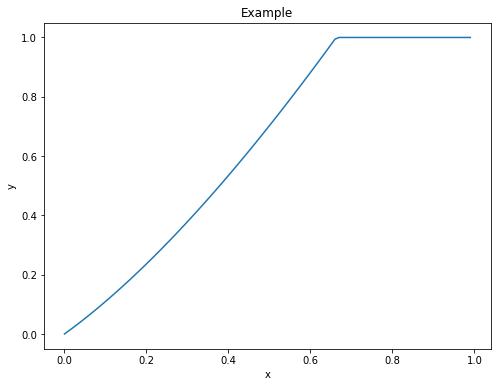

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))  # 定义图的大小
plt.xlabel("x")     # X轴标签
plt.ylabel("y")        # Y轴坐标标签
plt.title("Example")      #  曲线图的标题

plt.plot(a,b)            # 绘制曲线图
#在ipython的交互环境中需要这句话才能显示出来
plt.show()